In [6]:
# import some necessary librairies

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
%matplotlib inline
import matplotlib.pyplot as plt  # Matlab-style plotting
plt.style.use('fivethirtyeight') # a style of matplotlib
import seaborn as sns
color = sns.color_palette()
sns.set_style('darkgrid')
import warnings
def ignore_warn(*args, **kwargs):
    pass
warnings.warn = ignore_warn #ignore annoying warning (from sklearn and seaborn)


from scipy import stats
from scipy.stats import norm, skew #f or some statistics


pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x)) #Limiting floats output to 3 decimal points


from subprocess import check_output
print(check_output(["ls", "../../raw/CarsSaleForecast"]).decode("utf8")) #check the files available in the directory

[new] yancheng_train_20171226.csv
yancheng_testA_20171225.csv



# Part1: Exploratory Data Analysis(EDA)

In [8]:
# Now let's import and put the train and test datasets in  pandas dataframe

df_train = pd.read_csv('../../raw/CarsSaleForecast/[new] yancheng_train_20171226.csv')
df_test = pd.read_csv('../../raw/CarsSaleForecast/yancheng_testA_20171225.csv')

In [6]:
df_train.head(5)

,sale_date,class_id,sale_quantity,brand_id,compartment,type_id,level_id,department_id,TR,gearbox_type,...,engine_torque,car_length,car_width,car_height,total_quality,equipment_quality,rated_passenger,wheelbase,front_track,rear_track
0,201609,289403,94,12,2,1,1,1,6,MT,...,170,4440,1833,1545,1695,1320,5,2700,1556,1562
1,201609,745137,435,637,3,2,1,2,6,DCT,...,159,4534,1823,1483,1711,1336,5,2648,1553,1544
2,201609,714860,180,831,3,2,2,3,6,AT,...,176,4720,1815,1465,1860,1459,5,2770,1579,1589
3,201609,175962,40,750,3,2,1,4,6,AT,...,155,4475,1706,1469,1625,1145,5,2603,1460,1500
4,201609,270690,19,98,2,3,3,1,5,MT,...,146.5,4415,1685,1850,1825,1236,5,2720,1420,1440


In [7]:
df_test.head(5)

,predict_date,class_id,predict_quantity
0,201711,103507,nan
1,201711,124140,nan
2,201711,125403,nan
3,201711,136916,nan
4,201711,169673,nan


In [8]:
# check the numbers of samples and features
print("The train data size before dropping Id feature is : {} ".format(df_train.shape))
print("The test data size before dropping Id feature is : {} ".format(df_test.shape))

The train data size before dropping Id feature is : (20157, 32) 
The test data size before dropping Id feature is : (140, 3) 


In [9]:
# 检查缺损值, 发现无缺损
df_train.isnull().sum()

sale_date                0
class_id                 0
sale_quantity            0
brand_id                 0
compartment              0
type_id                  0
level_id                 0
department_id            0
TR                       0
gearbox_type             0
displacement             0
if_charging              0
price_level              0
price                    0
driven_type_id           0
fuel_type_id             0
newenergy_type_id        0
emission_standards_id    0
if_MPV_id                0
if_luxurious_id          0
power                    0
cylinder_number          0
engine_torque            0
car_length               0
car_width                0
car_height               0
total_quality            0
equipment_quality        0
rated_passenger          0
wheelbase                0
front_track              0
rear_track               0
dtype: int64

## Analysing The Features

### sale_quantity

In [10]:
# first: analysing 'sale_quantity'

df_train['sale_quantity'].describe()

count   20157.000
mean      126.312
std       231.137
min         5.000
25%        16.000
50%        47.000
75%       142.000
max      6284.000
Name: sale_quantity, dtype: float64

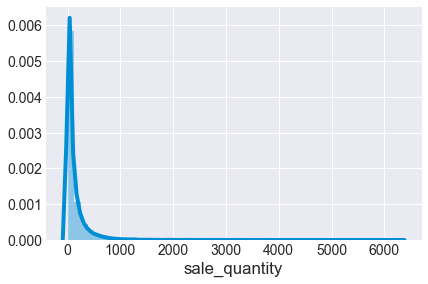

In [11]:
# histogram
sns.distplot(df_train['sale_quantity'])
plt.show()

* 数据有非常严重的偏移

In [12]:
# skewness and kurtosis
print("Skewness: %f" % df_train['sale_quantity'].skew())
print("Kurtosis: %f" % df_train['sale_quantity'].kurt())

Skewness: 6.106669
Kurtosis: 69.185909



 mu = 3.94 and sigma = 1.34



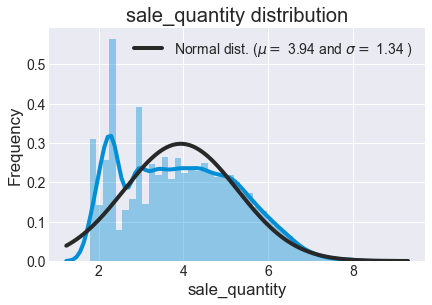

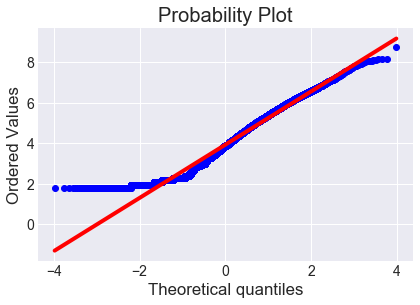

In [13]:
# Log-transformation of the target variable
df_train["sale_quantity"] = np.log1p(df_train["sale_quantity"])

#Check the new distribution 
sns.distplot(df_train['sale_quantity'] , fit=norm);

# Get the fitted parameters used by the function
(mu, sigma) = norm.fit(df_train['sale_quantity'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

#Now plot the distribution
plt.legend(['Normal dist. ($\mu=$ {:.2f} and $\sigma=$ {:.2f} )'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.title('sale_quantity distribution')

#Get also the QQ-plot
fig = plt.figure()
res = stats.probplot(df_train['sale_quantity'], plot=plt)
plt.show()

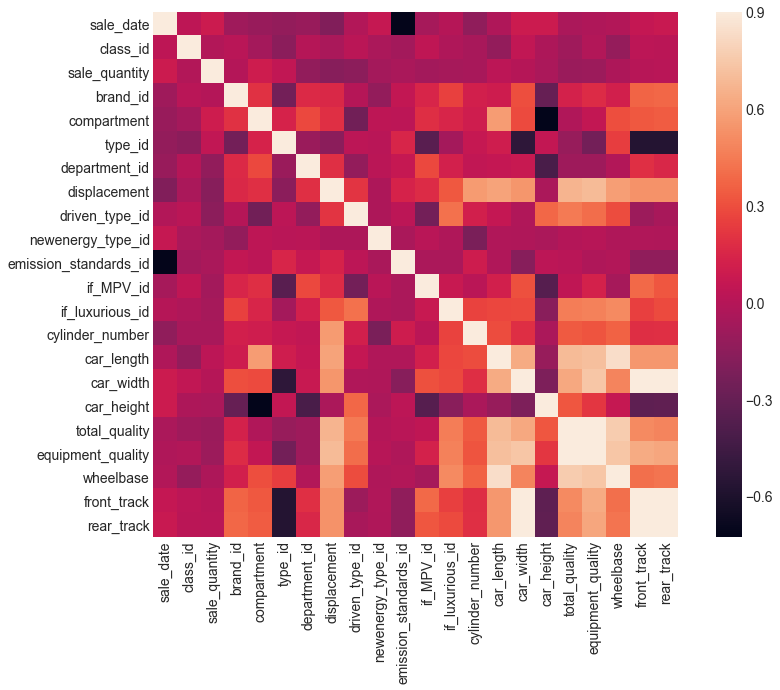

In [14]:
#Correlation map to see how features are correlated with SalePrice
corrmat = df_train.corr()
plt.subplots(figsize=(12,9))
sns.heatmap(corrmat, vmax=0.9, square=True)

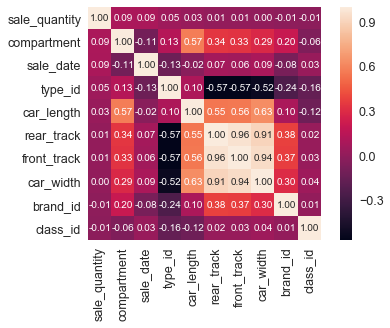

In [15]:
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'sale_quantity')['sale_quantity'].index
cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

* 数据处理之前, 没有任何一个特征与 sale_quantity 有良好的正相关性
* 每个指标都不能很好的预测结果
* 需要进一步挖掘特征
* 不能单纯锚定一个特征进行分析, sale_quantity 是离散变化的, 得先根据 class_id 处理一次才能用